In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

from astroML.utils.decorators import pickle_results
from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
"""
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=25, usetex=False)
"""

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

'\nif "setup_text_plots" not in globals():\n    from astroML.plotting import setup_text_plots\nsetup_text_plots(fontsize=25, usetex=False)\n'

Text(0, 0.5, 'kin_age')

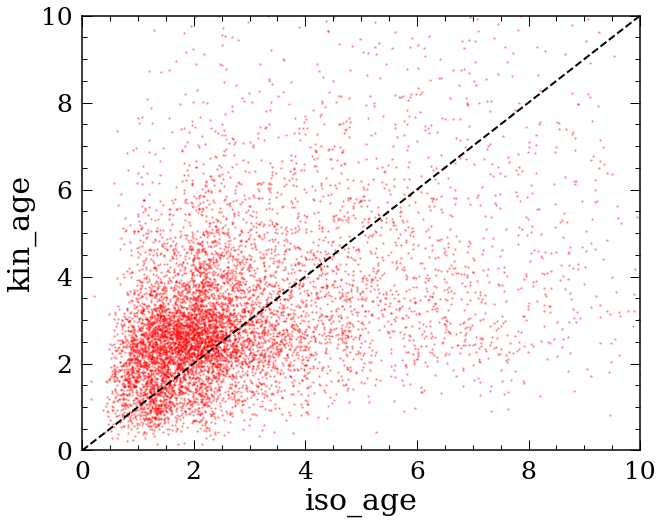

In [2]:
df_prot_s=pd.read_pickle('IsoStars.pkl')
df_ruth=pd.read_pickle('df_ruth_newbin.pkl')

df_prot_s=pd.merge(df_prot_s,df_ruth[['KID','kin_age_err']],left_on='KID',right_on='KID')

df_prot_s=df_prot_s.dropna(subset=['iso_age','kin_age'])

df_prot_s=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s=df_prot_s.loc[df_prot_s['iso_age_err1']<3]
df_prot_s=df_prot_s.dropna(subset=['iso_age','iso_age_err1','kin_age','kin_age_err_y'])

iso = df_prot_s.iso_age_ave.values
kin = df_prot_s.kin_age.values

# stack the results for computation
X = np.vstack([iso, kin]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([df_prot_s.iso_age_err1.values ** 2, df_prot_s.kin_age_err_y.values ** 2]).T

plt.figure(figsize=(10,8))
plt.plot(iso, kin, 'r.', markersize=3, alpha=.3)
plt.plot([0,10], [0,10], 'k--')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('iso_age')
plt.ylabel('kin_age')


In [5]:
#------------------------------------------------------------
# compute and save results
@pickle_results("XD_newbin.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    print('computing')
    clf = XDGMM(n_components, max_iter=max_iter)
    print('fitting')
    clf.fit(X, Xerr)
    print('finish')
    return clf

clf = compute_XD_results(10, 500)
sample = clf.sample(200)


@pickle_results: computing results and saving to 'XD_newbin.pkl'
computing
fitting
finish


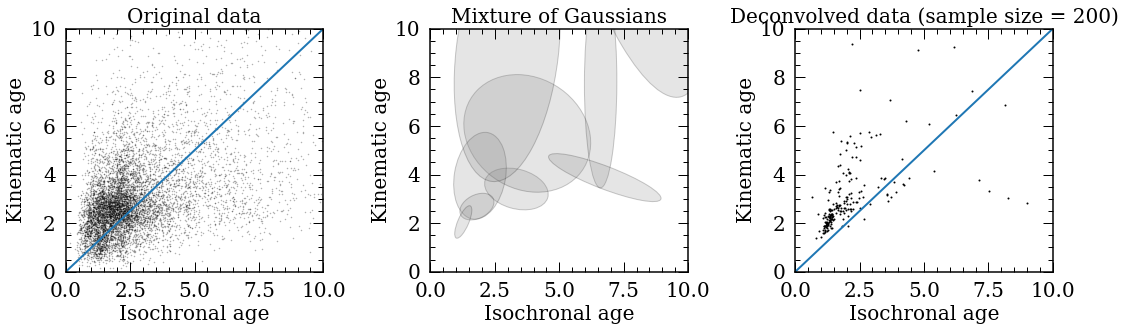

In [6]:
plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': False}
plt.rcParams.update(plotpar)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(16, 5))
# fig.subplots_adjust(left=0.1, right=0.95,
#                     bottom=0.1, top=0.95,
#                     wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(131)
ax1.plot(iso, kin, "k.", ms=1, alpha=.3)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10);
xs = np.linspace(0, 10, 100)
ax1.plot(xs, xs)
ax1.set_xlabel("Isochronal age")
ax1.set_ylabel("Kinematic age")
ax1.set_title("Original data", fontsize=20)

ax2 = fig.add_subplot(132)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax2,
                 ec='k', fc='gray', alpha=0.2)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
ax2.set_xlabel("Isochronal age")
ax2.set_ylabel("Kinematic age")
ax2.set_title("Mixture of Gaussians", fontsize=20)
    
ax3 = fig.add_subplot(133)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10);
ax3.plot(xs, xs)
ax3.set_xlabel("Isochronal age")
ax3.set_ylabel("Kinematic age");
ax3.set_title("Deconvolved data (sample size = 200)", fontsize=20);

plt.tight_layout()
np.save('XD_Prot',sample)

plt.savefig('XD.png')

# Rvar

Text(0, 0.5, 'kin_age')

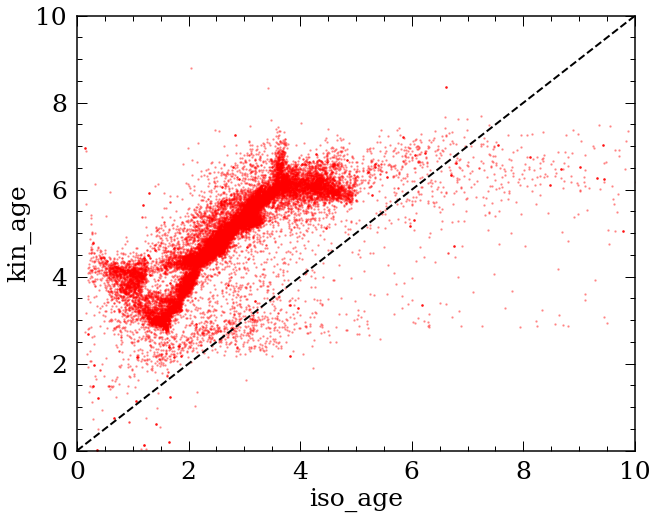

In [3]:
df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')
df_rvar_s=df_rvar_s.dropna(subset=['iso_age_ave','kin_age','iso_age_err','kin_age_err_bs'])

df_rvar_s=df_rvar_s.loc[df_rvar_s['iso_age']<10]
df_rvar_s=df_rvar_s.loc[df_rvar_s['iso_age_err1']<3]
df_rvar_s=df_rvar_s.dropna(subset=['iso_age','iso_age_err','kin_age'])

iso = df_rvar_s.iso_age_ave.values
kin = df_rvar_s.kin_age.values

# stack the results for computation
X = np.vstack([iso, kin]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([df_rvar_s.iso_age_err.values ** 2, df_rvar_s.kin_age_err ** 2]).T

plt.figure(figsize=(10,8))
plt.plot(iso, kin, 'r.', markersize=3, alpha=.3)
plt.plot([0,10], [0,10], 'k--')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('iso_age')
plt.ylabel('kin_age')

In [4]:
#------------------------------------------------------------
# compute and save results
@pickle_results("XD_toy_rvar.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    print('computing')
    clf = XDGMM(n_components, max_iter=max_iter)
    print('fitting')
    clf.fit(X, Xerr)
    print('finish')
    return clf

clf = compute_XD_results(10, 500)
sample = clf.sample(1000)

@pickle_results: using precomputed results from 'XD_toy_rvar.pkl'


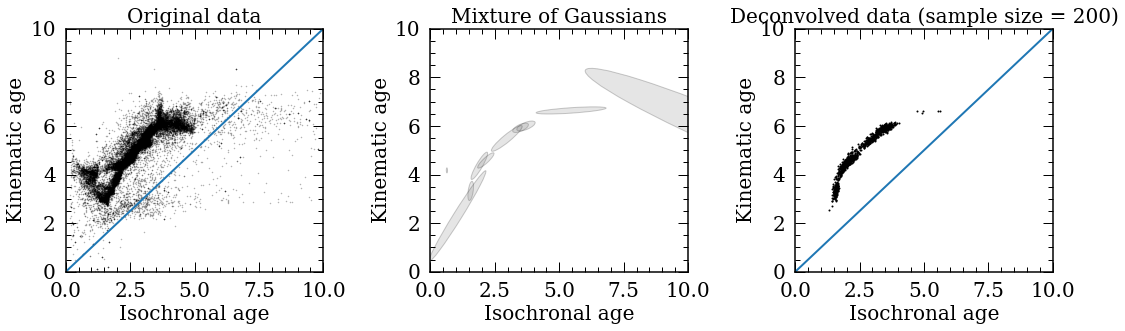

In [6]:
plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': False}
plt.rcParams.update(plotpar)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(16, 5))
# fig.subplots_adjust(left=0.1, right=0.95,
#                     bottom=0.1, top=0.95,
#                     wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(131)
ax1.plot(iso, kin, "k.", ms=1, alpha=.3)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10);
xs = np.linspace(0, 10, 100)
ax1.plot(xs, xs)
ax1.set_xlabel("Isochronal age")
ax1.set_ylabel("Kinematic age")
ax1.set_title("Original data", fontsize=20)

ax2 = fig.add_subplot(132)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax2,
                 ec='k', fc='gray', alpha=0.2)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
ax2.set_xlabel("Isochronal age")
ax2.set_ylabel("Kinematic age")
ax2.set_title("Mixture of Gaussians", fontsize=20)
    
ax3 = fig.add_subplot(133)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10);
ax3.plot(xs, xs)
ax3.set_xlabel("Isochronal age")
ax3.set_ylabel("Kinematic age");
ax3.set_title("Deconvolved data (sample size = 200)", fontsize=20);
np.save('XD_Rvar',sample)
plt.tight_layout()
plt.savefig('XD_rvar.png')

# predicted Prot

Text(0, 0.5, 'kin_age')

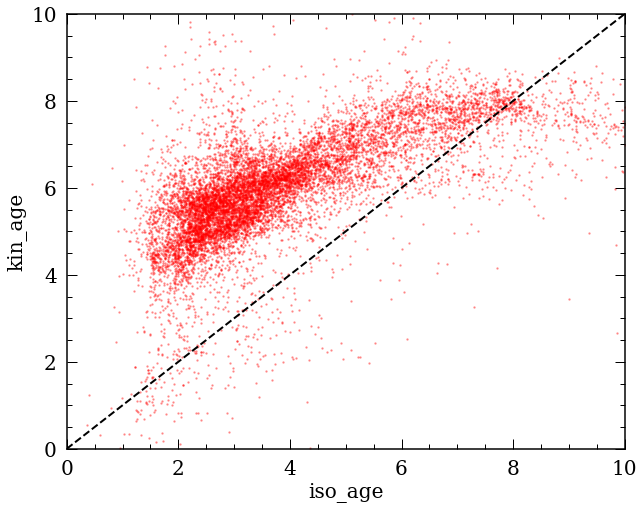

In [11]:
df_rvar_s=pd.read_pickle('KinageAllKepler.pkl')
df_rvar_s=df_rvar_s.dropna(subset=['iso_age_ave','kin_age','iso_age_err1','kin_age_err_bs'])

df_rvar_s=df_rvar_s.loc[df_rvar_s['iso_age']<10]
df_rvar_s=df_rvar_s.loc[df_rvar_s['iso_age_err1']<3]
df_rvar_s=df_rvar_s.dropna(subset=['iso_age','iso_age_err1','kin_age'])

iso = df_rvar_s.iso_age_ave.values
kin = df_rvar_s.kin_age.values

# stack the results for computation
X = np.vstack([iso, kin]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([df_rvar_s.iso_age_err1.values ** 2, df_rvar_s.kin_age_err_bs ** 2]).T

plt.figure(figsize=(10,8))
plt.plot(iso, kin, 'r.', markersize=3, alpha=.3)
plt.plot([0,10], [0,10], 'k--')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('iso_age')
plt.ylabel('kin_age')

In [12]:
#------------------------------------------------------------
# compute and save results
@pickle_results("XD_toy_protrvar.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    print('computing')
    clf = XDGMM(n_components, max_iter=max_iter)
    print('fitting')
    clf.fit(X, Xerr)
    print('finish')
    return clf

clf = compute_XD_results(10, 500)
sample = clf.sample(1000)

@pickle_results: computing results and saving to 'XD_toy_protrvar.pkl'
computing
fitting


/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


finish


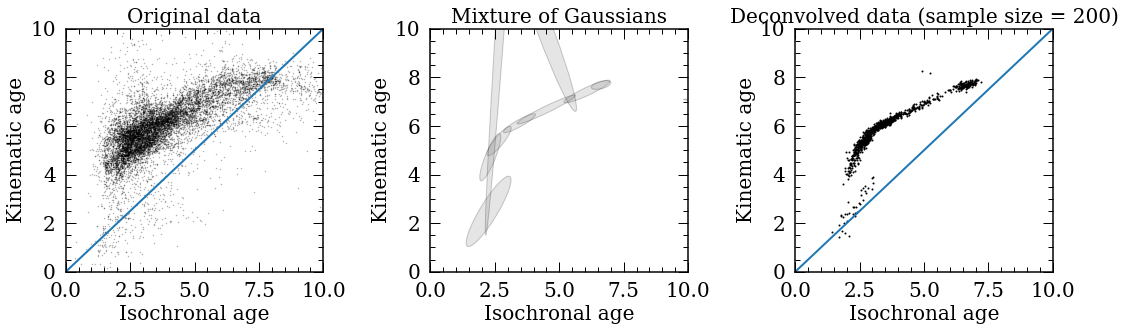

In [14]:
plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': False}
plt.rcParams.update(plotpar)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(16, 5))
# fig.subplots_adjust(left=0.1, right=0.95,
#                     bottom=0.1, top=0.95,
#                     wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(131)
ax1.plot(iso, kin, "k.", ms=1, alpha=.3)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10);
xs = np.linspace(0, 10, 100)
ax1.plot(xs, xs)
ax1.set_xlabel("Isochronal age")
ax1.set_ylabel("Kinematic age")
ax1.set_title("Original data", fontsize=20)

ax2 = fig.add_subplot(132)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax2,
                 ec='k', fc='gray', alpha=0.2)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
ax2.set_xlabel("Isochronal age")
ax2.set_ylabel("Kinematic age")
ax2.set_title("Mixture of Gaussians", fontsize=20)
    
ax3 = fig.add_subplot(133)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10);
ax3.plot(xs, xs)
ax3.set_xlabel("Isochronal age")
ax3.set_ylabel("Kinematic age");
ax3.set_title("Deconvolved data (sample size = 200)", fontsize=20);
np.save('XD_Rvar',sample)
plt.tight_layout()
plt.savefig('XD_protrvar.png')

# final

(8568, 44)
(8551, 44)


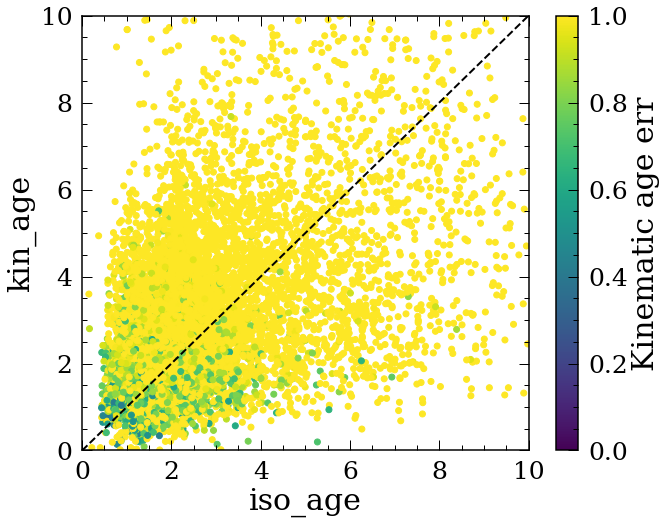

In [2]:
df_prot_s=pd.read_pickle('IsoStars.pkl')
df_prot_s=df_prot_s.dropna(subset=['iso_age_ave','kin_age'])

df_prot_s=df_prot_s.loc[df_prot_s['iso_age_ave']<10]
df_prot_s=df_prot_s.loc[df_prot_s['iso_age_err1']<3]

df_prot_s=df_prot_s.dropna(subset=['iso_age_ave','iso_age_err1','kin_age_err','kin_age'])
print(np.shape(df_prot_s))
df_prot_s=df_prot_s.loc[~(df_prot_s['iso_age_ave']==0)]
df_prot_s=df_prot_s.loc[~(df_prot_s['iso_age_err1']==0)]
df_prot_s=df_prot_s.loc[~(df_prot_s['kin_age_err']==0)]
df_prot_s=df_prot_s.loc[~(df_prot_s['kin_age']==0)]

df_prot_s=df_prot_s.loc[(df_prot_s['kin_age']<20)]
df_prot_s=df_prot_s.loc[(df_prot_s['kin_age_err']<20)]
print(np.shape(df_prot_s))

iso = df_prot_s.iso_age_ave.values
kin = df_prot_s.kin_age.values

# stack the results for computation
X = np.vstack([iso, kin]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([df_prot_s.iso_age_err1.values ** 2, df_prot_s.kin_age_err.values ** 2]).T

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_prot_s['iso_age_ave'], df_prot_s['kin_age'], c=df_prot_s['kin_age_err'],vmin=0,vmax=1)
plt.plot([0,10], [0,10], 'k--')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('iso_age')
plt.ylabel('kin_age')
cb=plt.colorbar()

cb.set_label('Kinematic age err')




In [3]:
np.average(df_prot_s['kin_age_err'])

1.548919222439101

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121440a90>,
      dtype=object)

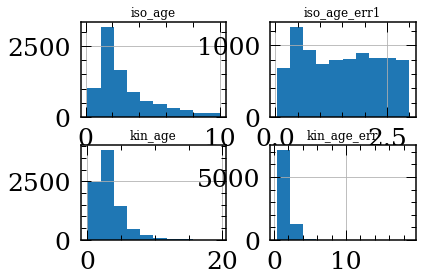

In [4]:
df_prot_s[['iso_age','iso_age_err1','kin_age_err','kin_age']].hist()

In [5]:
max(df_prot_s['kin_age'])


19.606431665447417

In [6]:
#------------------------------------------------------------
# compute and save results
@pickle_results("XD_toy_newProt_redo.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    print('computing')
    clf = XDGMM(n_components, max_iter=max_iter)
    print('fitting')
    clf.fit(X, Xerr)
    print('finish')
    return clf

clf = compute_XD_results(10, 500)
sample = clf.sample(300)


@pickle_results: using precomputed results from 'XD_toy_newProt_redo.pkl'


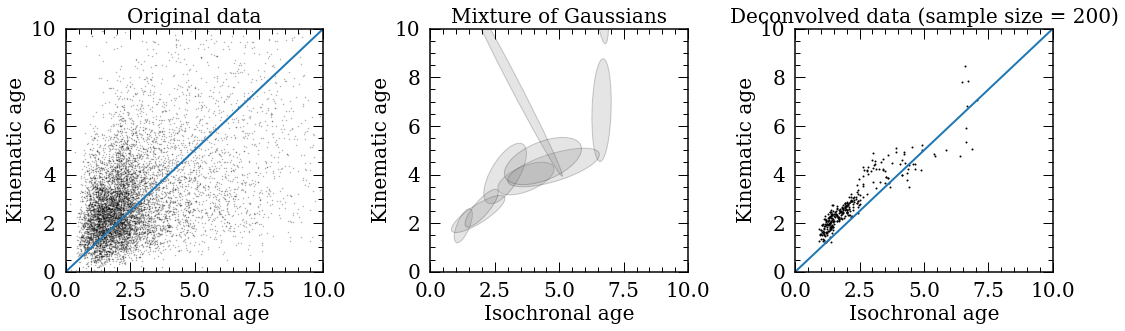

In [7]:
plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': False}
plt.rcParams.update(plotpar)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(16, 5))
# fig.subplots_adjust(left=0.1, right=0.95,
#                     bottom=0.1, top=0.95,
#                     wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(131)
ax1.plot(iso, kin, "k.", ms=1, alpha=.3)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10);
xs = np.linspace(0, 10, 100)
ax1.plot(xs, xs)
ax1.set_xlabel("Isochronal age")
ax1.set_ylabel("Kinematic age")
ax1.set_title("Original data", fontsize=20)

ax2 = fig.add_subplot(132)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax2,
                 ec='k', fc='gray', alpha=0.2)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
ax2.set_xlabel("Isochronal age")
ax2.set_ylabel("Kinematic age")
ax2.set_title("Mixture of Gaussians", fontsize=20)
    
ax3 = fig.add_subplot(133)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10);
ax3.plot(xs, xs)
ax3.set_xlabel("Isochronal age")
ax3.set_ylabel("Kinematic age");
ax3.set_title("Deconvolved data (sample size = 200)", fontsize=20);
np.save('XD_prot',sample)
plt.tight_layout()
plt.savefig('XD_protrvar.png')

# Predicted

/Users/lucy/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (187,188,194,224,225) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(16160, 6)
(16140, 6)


Text(0.5, 1.0, 'K/M Stars')

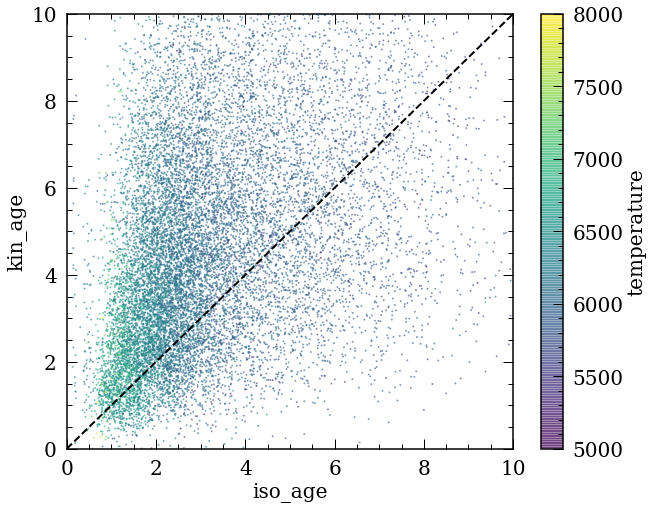

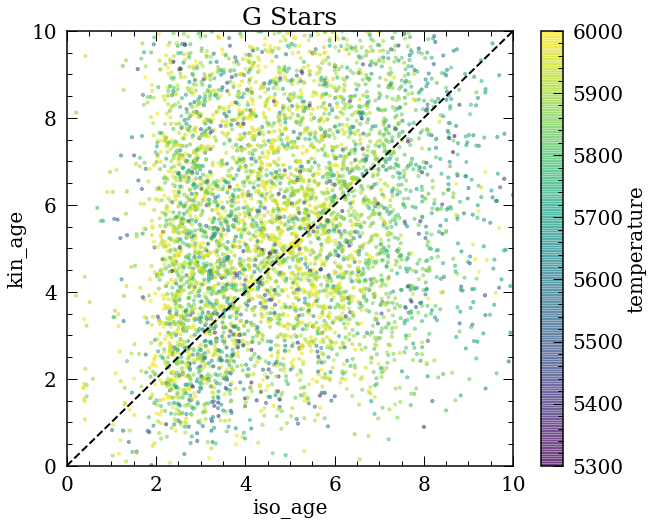

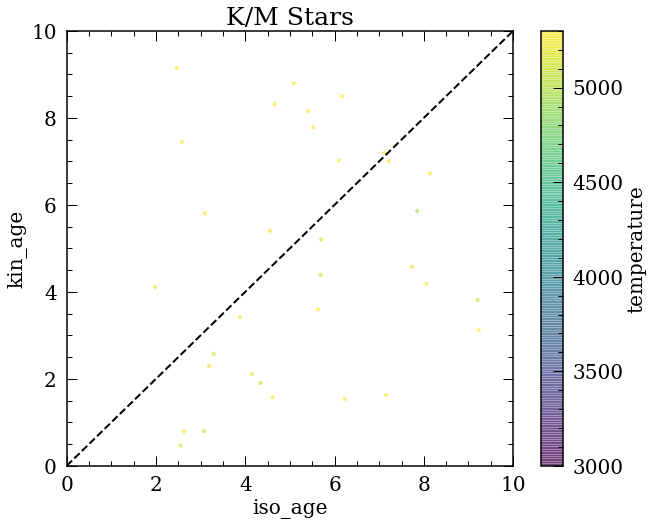

In [12]:
#df=pd.read_pickle('KinageAllKepler_cut_redo.pkl')
df=pd.read_pickle('KinageAllKepler_cut_random.pkl')



df_prot_s=pd.read_table('IsoStars_all.csv',delimiter=',')
df_prot_s=pd.merge(df_prot_s[['KID','iso_age_ave','iso_age_err1']],df[['KID','kin_age','kin_age_err','teff_calc']],how='inner')

df_prot_s=df_prot_s.dropna(subset=['iso_age_ave','kin_age','kin_age_err'])

df_prot_s=df_prot_s.loc[df_prot_s['iso_age_ave']<10]
df_prot_s=df_prot_s.loc[df_prot_s['iso_age_err1']<3]

df_prot_s=df_prot_s.dropna(subset=['iso_age_ave','iso_age_err1','kin_age'])
print(np.shape(df_prot_s))
df_prot_s=df_prot_s.loc[~(df_prot_s['iso_age_ave']==0)]
df_prot_s=df_prot_s.loc[~(df_prot_s['iso_age_err1']==0)]
df_prot_s=df_prot_s.loc[~(df_prot_s['kin_age']==0)]

df_prot_s=df_prot_s.loc[(df_prot_s['kin_age']<20)]
print(np.shape(df_prot_s))

iso = df_prot_s.iso_age_ave.values
kin = df_prot_s.kin_age.values

# stack the results for computation
X = np.vstack([iso, kin]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([df_prot_s.iso_age_err1.values ** 2, 
                                 df_prot_s.kin_age_err.values** 2]).T

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_prot_s['iso_age_ave'], df_prot_s['kin_age'], c=df_prot_s['teff_calc'],s=1,alpha=.5,vmin=5000,vmax=8000)
plt.plot([0,10], [0,10], 'k--')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('iso_age')
plt.ylabel('kin_age')
cb=plt.colorbar()
cb.set_label('temperature')


plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
temrange=[5300,6000]
df_prot_s_plot=df_prot_s.loc[df_prot_s['teff_calc']>temrange[0]]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['teff_calc']<temrange[1]]
plt.scatter(df_prot_s_plot['iso_age_ave'], df_prot_s_plot['kin_age'], 
            c=df_prot_s_plot['teff_calc'],s=10,alpha=.5,vmin=temrange[0],vmax=temrange[1])
plt.plot([0,10], [0,10], 'k--')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('iso_age')
plt.ylabel('kin_age')
cb=plt.colorbar()
cb.set_label('temperature')
plt.title('G Stars',fontsize=25)


plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
temrange=[3000,5300]
df_prot_s_plot=df_prot_s.loc[df_prot_s['teff_calc']>temrange[0]]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['teff_calc']<temrange[1]]
plt.scatter(df_prot_s_plot['iso_age_ave'], df_prot_s_plot['kin_age'], 
            c=df_prot_s_plot['teff_calc'],s=10,alpha=.5,vmin=temrange[0],vmax=temrange[1])
plt.plot([0,10], [0,10], 'k--')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel('iso_age')
plt.ylabel('kin_age')
cb=plt.colorbar()
cb.set_label('temperature')
plt.title('K/M Stars',fontsize=25)




/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Temperature [K]')

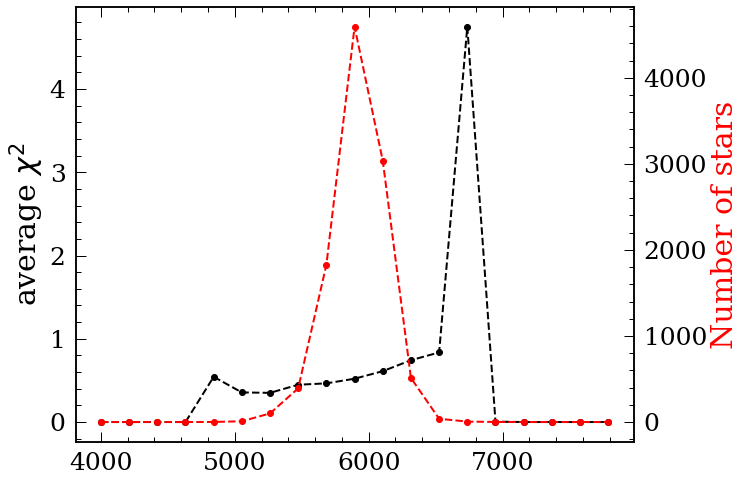

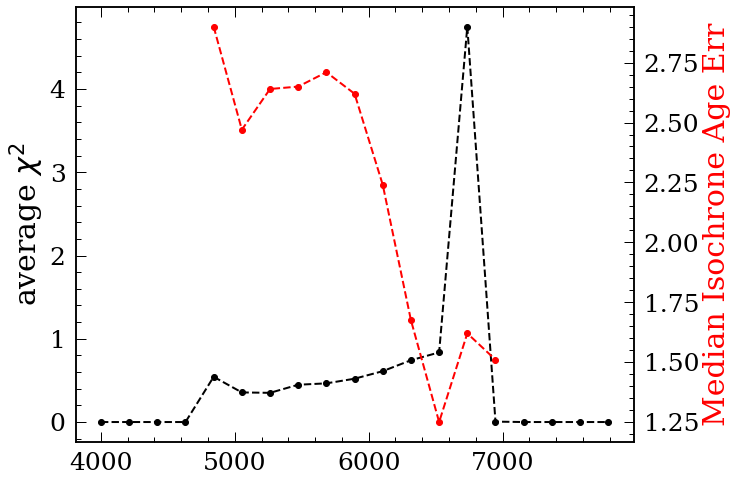

In [3]:
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

binsize=20
bins=np.linspace(4000,8000,binsize)
chisqs=np.zeros(binsize-1)
starnumb=np.zeros(binsize-1)
isoageerr=np.zeros(binsize-1)
for i in range(len(bins)-1):
    lowertemp=bins[i]
    uppertemp=bins[i+1]
    locdf=df_prot_s.loc[df_prot_s['teff_calc']>lowertemp]
    locdf=locdf.loc[locdf['teff_calc']<uppertemp]
    chisqs[i]=calcChi2(locdf['iso_age_ave'],locdf['kin_age'],locdf['iso_age_err1'],locdf['kin_age_err'])
    starnumb[i]=len(locdf)
    isoageerr[i]=np.median(locdf['iso_age_err1'].dropna())

plt.figure(figsize=(10,8))
plt.plot(bins[:-1],chisqs,'k--o')
plt.ylabel('average $\chi^2$',color='k')
plt.twinx()
plt.plot(bins[:-1],starnumb,'r--o')
plt.ylabel('Number of stars',color='r')
plt.xlabel('Temperature [K]')


plt.figure(figsize=(10,8))
plt.plot(bins[:-1],chisqs,'k--o')
plt.ylabel('average $\chi^2$',color='k')
plt.twinx()
plt.plot(bins[:-1],isoageerr,'r--o')
plt.ylabel('Median Isochrone Age Err',color='r')
plt.xlabel('Temperature [K]')

In [4]:
np.average(df_prot_s_plot['kin_age_err'])

4.71077034499509

In [14]:
#------------------------------------------------------------
# compute and save results
@pickle_results("XD_toy_predictProt_random.pkl")
def compute_XD_results(n_components=10, max_iter=500):
    print('computing')
    clf = XDGMM(n_components, max_iter=max_iter)
    print('fitting')
    clf.fit(X, Xerr)
    print('finish')
    return clf

clf = compute_XD_results(10, 500)
sample = clf.sample(300)
np.save('XD',sample)

@pickle_results: computing results and saving to 'XD_toy_predictProt_random.pkl'
computing
fitting
finish


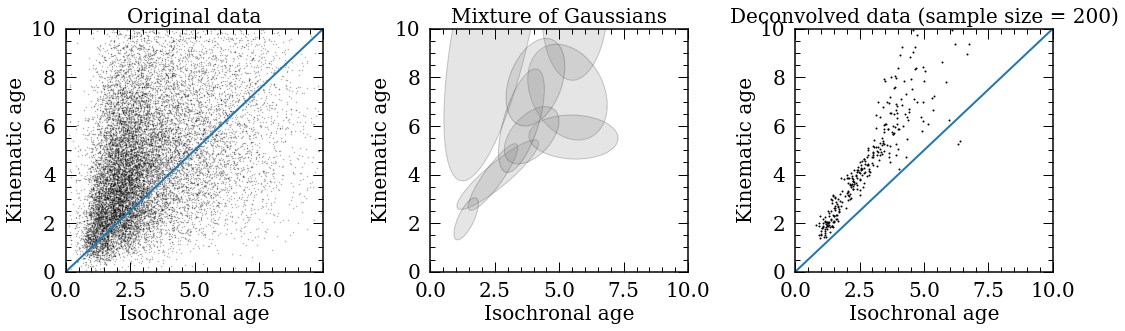

In [16]:
plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': False}
plt.rcParams.update(plotpar)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(16, 5))
# fig.subplots_adjust(left=0.1, right=0.95,
#                     bottom=0.1, top=0.95,
#                     wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(131)
ax1.plot(iso, kin, "k.", ms=1, alpha=.3)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10);
xs = np.linspace(0, 10, 100)
ax1.plot(xs, xs)
ax1.set_xlabel("Isochronal age")
ax1.set_ylabel("Kinematic age")
ax1.set_title("Original data", fontsize=20)

ax2 = fig.add_subplot(132)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax2,
                 ec='k', fc='gray', alpha=0.2)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
ax2.set_xlabel("Isochronal age")
ax2.set_ylabel("Kinematic age")
ax2.set_title("Mixture of Gaussians", fontsize=20)
    
ax3 = fig.add_subplot(133)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 10);
ax3.plot(xs, xs)
ax3.set_xlabel("Isochronal age")
ax3.set_ylabel("Kinematic age");
ax3.set_title("Deconvolved data (sample size = 200)", fontsize=20);
np.save('XD_all',sample)
plt.tight_layout()
plt.savefig('XD_protrvar.png')

In [19]:
z=np.polyfit(sample[:, 0], sample[:, 1],1)
#correction_age=df['kin_age']-(df['kin_age']*z[0]+z[1]-df['kin_age'])
correction_age=(sample[:, 1]-z[1])/z[0]


In [23]:
z

array([1.44936103, 1.17263935])

(0, 10)

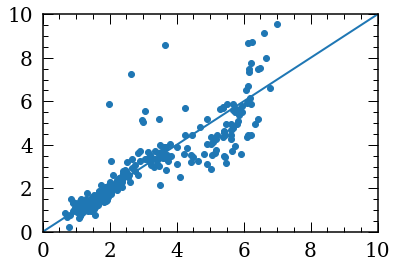

In [20]:
plt.scatter(sample[:, 0],correction_age)
plt.plot([0,10],[0,10])
plt.xlim([0,10])
plt.ylim([0,10])

In [21]:
df['kin_age_correct']=(df['kin_age']-z[1])/z[0]

In [22]:
df.to_pickle('KinageAllKepler_cut_redo.pkl')